In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_modeling import *
from data_analysis import *

## Load data

In [5]:
# Load the forecasting model data 
data = pd.read_csv('../data/ml_data_panel.csv')

# Ensure sector is categorical once (helps consistency)
data = data.astype({'sector': 'category'})

# Load feature labels
labels = load_char_labels()
identifiers = ['tic', 'conm', 'year', 'month', 'date']
stock_chars, acc_ratios = labels['stock_chars'], labels['acc_ratios']
targets = ['target_exret']

# Remove redundant or problematic features
acc_ratios.remove('rd_sale')
acc_ratios.remove('rd_me')

# Prep data

In [ ]:
# Set the date type and create a proper date column
data['date'] = pd.to_datetime(data[['year','month']].assign(DAY=1)) + pd.offsets.MonthEnd(0)

# Winsorize the target variable within each sector
q_lo = data.groupby('sector',  observed=False)['target_exret'].transform(lambda s: s.quantile(0.10))
q_hi = data.groupby('sector',  observed=False)['target_exret'].transform(lambda s: s.quantile(0.90))
data['target_exret'] = data['target_exret'].clip(lower=q_lo, upper=q_hi)
data.head()

,date,year,month,tic,conm,sector,subsector,market_equity,dolvol_126d,turnover_126d,...,niq_be,ocf_at,gp_at,niq_at,op_at,be_me,div12m_me,ni_me,sale_me,target_exret
0,2005-02-28,2005,2,JJSF,J & J SNACK FOODS CORP,Consumer Staples,Food & Kindred Products,436.469500,1.027584e+06,0.002604,...,0.041494,0.169935,0.590511,0.033460,0.211968,0.525235,0.002584,0.052031,0.954449,-0.023154
1,2005-02-28,2005,2,PLXS,PLEXUS CORP,Information Technology,Electronic & Other Electrical (incl. 367 semis),497.652500,5.409342e+06,0.010524,...,-0.095016,-0.039127,0.205654,-0.064130,0.080571,0.706141,0.000000,-0.063458,2.091536,-0.081461
2,2005-02-28,2005,2,MSFT,MICROSOFT CORP,Information Technology,"Business Services (incl. computer programming,...",285932.241630,5.725156e+08,0.006475,...,0.033785,0.161338,0.341675,0.027363,0.224901,0.265608,0.120160,0.028265,0.132231,-0.041174
3,2005-02-28,2005,2,RGEN,REPLIGEN CORP,Materials,Chemicals & Allied,69.170199,3.639339e+05,0.005309,...,-0.064646,-0.134410,0.183160,-0.059221,0.038262,0.359664,0.000000,-0.111999,0.109006,-0.128452
4,2005-02-28,2005,2,DLHC,DLH HOLDINGS CORP,Information Technology,"Business Services (incl. computer programming,...",30.689669,3.179099e+04,0.000900,...,-0.004581,-0.031874,0.233589,-0.003668,-0.070213,1.009884,0.000000,-0.057511,1.215002,-0.034048


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247593 entries, 0 to 247592
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           247593 non-null  datetime64[ns]
 1   year           247593 non-null  int64         
 2   month          247593 non-null  int64         
 3   tic            247593 non-null  object        
 4   conm           247593 non-null  object        
 5   sector         247593 non-null  category      
 6   subsector      247593 non-null  object        
 7   market_equity  247593 non-null  float64       
 8   dolvol_126d    247593 non-null  float64       
 9   turnover_126d  247593 non-null  float64       
 10  ivol_ff3_21d   247593 non-null  float64       
 11  ni_ivol        247593 non-null  float64       
 12  beta_60m       247593 non-null  float64       
 13  z_score        247593 non-null  float64       
 14  f_score        247593 non-null  float64       
 15  

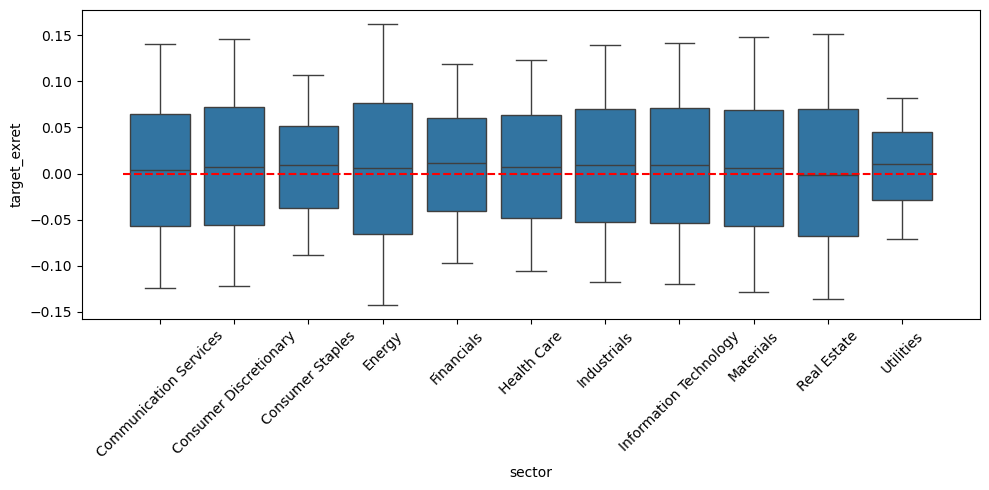

In [14]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(data=data, x="sector", y="target_exret")
ax.set_xlabel("sector"); ax.set_ylabel("target_exret")
ax.tick_params(axis='x', rotation=45)
plt.hlines(y=0, xmin=-0.5, xmax=len(data['sector'].unique())-0.5, colors='r', linestyles='dashed')
plt.tight_layout(); plt.show()

In [ ]:
# outlier_low_quantile = 0.1
# outlier_high_quantile = 0.9

# # Determine the quantile thresholds for each sector
# thr_low = data.groupby('sector', observed=True)['target_exret'].transform(lambda s: s.quantile(outlier_low_quantile))
# thr_high = data.groupby('sector', observed=True)['target_exret'].transform(lambda s: s.quantile(outlier_high_quantile))

# # Filter the DataFrame to exclude outliers based on sector-specific thresholds
# data = data.loc[(data['target_exret'] >= thr_low) & (data['target_exret'] <= thr_high)]

# # Plot the boxplot for each sector
# plt.figure(figsize=(10,5))
# ax = sns.boxplot(data=data, x="sector", y="target_exret")
# ax.set_xlabel("sector"); ax.set_ylabel("target_exret")
# ax.tick_params(axis='x', rotation=45)
# plt.hlines(y=0, xmin=-0.5, xmax=len(data['sector'].unique())-0.5, colors='r', linestyles='dashed')
# plt.tight_layout(); plt.show()


In [94]:
data.shape

(217282, 30)

### Predict the next period returns with a GBM

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgbfrom sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
# LightGBM parameters and settings
params = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'],   # you can add 'r2' on recent LightGBM versions
    'num_leaves': 250,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,     # optional regularization
    'bagging_fraction': 0.9,     # optional regularization
    'bagging_freq': 1,           # optional regularization
    'verbose': -1,
}
num_boost_round = 500            # params may require tuning



# Feature list and target
feats = stock_chars + acc_ratios + ['sector']
target_col = 'target_exret'
date_col = 'date'  

categorical_features = ['sector']

# Run time CV
n_splits, purge, embargo = 5, 1, 0  # typical starting point
fold_metrics = []                   # per-fold summary (R2, MSE, MAE)
models, evals_by_fold, folds = [], [], []

for tr_idx, va_idx in time_block_splits(data, date_col, n_splits=n_splits, purge=purge, embargo=embargo):
    X_tr = data.loc[tr_idx, feats]
    y_tr = data.loc[tr_idx, target_col].values
    X_va = data.loc[va_idx, feats]
    y_va = data.loc[va_idx, target_col].values

    model, evals_result = fit_lgb_fold_reg(
        X_tr, y_tr, X_va, y_va,
        cat_cols=categorical_features,
        params=params,
        num_boost_round=num_boost_round,
        early_stopping_rounds=50
    )
    models.append(model)
    evals_by_fold.append(evals_result)
    folds.append((tr_idx, va_idx))

    # fold-level predictions and metrics
    y_pred = model.predict(X_va, num_iteration=model.best_iteration)
    r2  = r2_score(y_va, y_pred)
    mse = mean_squared_error(y_va, y_pred)
    mae = mean_absolute_error(y_va, y_pred)
    fold_metrics.append({'r2': r2, 'mse': mse, 'mae': mae})

# Aggregate and report
fold_df = pd.DataFrame(fold_metrics)
print("Per-fold metrics:\n", fold_df)
print("\nCV mean perf | R2: {:.4f}, MSE: {:.6f}, MAE: {:.6f}".format(
    fold_df['r2'].mean(), fold_df['mse'].mean(), fold_df['mae'].mean()
))

Per-fold metrics:
          r2       mse       mae
0 -0.014965  0.005015  0.058248
1  0.007222  0.004095  0.052027
2  0.013180  0.004796  0.056764
3  0.005105  0.005489  0.062302

CV mean perf | R2: 0.0026, MSE: 0.004849, MAE: 0.057335


In [95]:
# (Optional) Build out-of-fold predictions for the whole sample (useful for backtests)
# Initialize NaNs, then fill validation slices with their fold predictions
oof = pd.Series(index=data.index, dtype=float)
for (tr_idx, va_idx), m in zip(folds, models):
    X_va = data.loc[va_idx, feats]
    oof.loc[va_idx] = m.predict(X_va, num_iteration=m.best_iteration)

# Now `oof` aligns with `data.index` and contains prediction for each row from the fold where it was "out-of-sample".
# You can compute OOF metrics overall:
mask = oof.notna()
oof_r2  = r2_score(data.loc[mask, target_col], oof.loc[mask])
oof_mse = mean_squared_error(data.loc[mask, target_col], oof.loc[mask])
oof_mae = mean_absolute_error(data.loc[mask, target_col], oof.loc[mask])
print("\nOOF perf     | R2: {:.4f}, MSE: {:.6f}, MAE: {:.6f}".format(oof_r2, oof_mse, oof_mae))



OOF perf     | R2: 0.0066, MSE: 0.004872, MAE: 0.057521


### ====================================================================
### Time-aware CV with Purge & Embargo + LightGBM (Classification: Up/Down)
### =======================================================================
### (A) Minimal utilities: time-block splitter (unchanged) + one-fold LightGBM classifier
### (B) Compact workflow snippet: run time-CV, evaluate, summarize, and build OOF preds

In [96]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# ---------------------------
# (A1) Time-blocked splits with purge & embargo  (same as before)
# ---------------------------
def time_block_splits(df, date_col, n_splits=5, purge=0, embargo=0):
    udates = np.array(sorted(df[date_col].unique()))
    blocks = np.array_split(udates, n_splits)

    for i in range(n_splits):
        val_dates = blocks[i]
        if val_dates.size == 0:
            continue
        train_dates = np.concatenate(blocks[:i]) if i > 0 else np.array([], dtype=udates.dtype)
        if purge > 0 and train_dates.size > purge:
            train_dates = train_dates[:-purge]
        if embargo > 0 and (i + 1) < len(blocks):
            emb_dates = blocks[i + 1][:embargo]
            if emb_dates.size > 0:
                train_dates = np.setdiff1d(train_dates, emb_dates, assume_unique=False)

        tr_idx = df.index[df[date_col].isin(train_dates)]
        va_idx = df.index[df[date_col].isin(val_dates)]
        if len(tr_idx) == 0 or len(va_idx) == 0:
            continue
        yield tr_idx, va_idx

# ---------------------------
# (A2) One-fold LightGBM fit (binary classification: up/down)
# ---------------------------
def fit_lgb_fold_clf(X_tr, y_tr, X_va, y_va, cat_cols, params, num_boost_round=500, early_stopping_rounds=50):
    """
    Trains a LightGBM binary classifier on one train/valid split.

    - Casts categorical columns to pandas 'category'
    - Uses early stopping against the validation set
    - Records evaluation metrics per boosting round in evals_result
    """
    for c in cat_cols:
        if c in X_tr.columns:
            X_tr.loc[:, c] = X_tr[c].astype('category')
        if c in X_va.columns:
            X_va.loc[:, c] = X_va[c].astype('category')

    feats = list(X_tr.columns)
    dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols, feature_name=feats)
    dva = lgb.Dataset(X_va, label=y_va, categorical_feature=cat_cols, feature_name=feats, reference=dtr)

    evals_result = {}
    model = lgb.train(
        {**params, 'verbose': -1},
        dtr,
        num_boost_round=num_boost_round,
        valid_sets=[dtr, dva],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False),
            lgb.record_evaluation(evals_result)
        ]
    )
    return model, evals_result

# ===========================
# (B) Workflow: time-CV classification (Up/Down at t+1)
# ===========================
# Assumptions:
# - DataFrame `data` has your feature columns + ['sector', 'target_exret', 'date']
# - We'll turn target_exret into a binary label: up=1 if >0 else 0 (you can change this rule)

# Hyperparameters (binary classification)
params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'num_leaves': 250,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': -1,
}
num_boost_round = 500
categorical_features = ['sector']

# Features / targets
feats = stock_chars + acc_ratios + ['sector']
target_cont = 'target_exret'   # original continuous next-period excess return
target_bin  = 'target_up'      # new binary label (1 if up, 0 if down)
date_col    = 'date'

# Derive binary target once
data = data.copy()
data[target_bin] = (data[target_cont] > 0).astype(int)

# Optional: ensure sector is categorical once (consistent handling)
if 'sector' in data.columns:
    data.loc[:, 'sector'] = data['sector'].astype('category')

# Time CV settings (same splitter)
n_splits, purge, embargo = 5, 1, 0
fold_metrics = []      # per-fold summary (ACC, AUC, F1, Precision, Recall)
models, evals_by_fold, folds = [], [], []

for tr_idx, va_idx in time_block_splits(data, date_col, n_splits=n_splits, purge=purge, embargo=embargo):
    X_tr = data.loc[tr_idx, feats]
    y_tr = data.loc[tr_idx, target_bin].values
    X_va = data.loc[va_idx, feats]
    y_va = data.loc[va_idx, target_bin].values

    model, evals_result = fit_lgb_fold_clf(
        X_tr, y_tr, X_va, y_va,
        cat_cols=categorical_features,
        params=params,
        num_boost_round=num_boost_round,
        early_stopping_rounds=50
    )
    models.append(model)
    evals_by_fold.append(evals_result)
    folds.append((tr_idx, va_idx))

    # fold-level predictions & metrics
    # LightGBM .predict outputs class probability for positive class in binary
    y_proba = model.predict(X_va, num_iteration=model.best_iteration)
    y_pred  = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_va, y_pred)
    try:
        auc = roc_auc_score(y_va, y_proba)
    except ValueError:
        auc = np.nan  # if a fold has only one class in y_va
    f1  = f1_score(y_va, y_pred, zero_division=0)
    prec = precision_score(y_va, y_pred, zero_division=0)
    rec  = recall_score(y_va, y_pred, zero_division=0)

    fold_metrics.append({'acc': acc, 'auc': auc, 'f1': f1, 'precision': prec, 'recall': rec})

# Aggregate and report
fold_df = pd.DataFrame(fold_metrics)
print("Per-fold metrics:\n", fold_df)
print("\nCV mean perf | ACC: {:.4f}, AUC: {:.4f}, F1: {:.4f}, P: {:.4f}, R: {:.4f}".format(
    fold_df['acc'].mean(), fold_df['auc'].mean(), fold_df['f1'].mean(),
    fold_df['precision'].mean(), fold_df['recall'].mean()
))

# (Optional) Build out-of-fold predictions for the whole sample (useful for trading/backtests)
# Store both probability and class for downstream thresholds/ROC
oof_proba = pd.Series(index=data.index, dtype=float)
oof_pred  = pd.Series(index=data.index, dtype=float)
for (tr_idx, va_idx), m in zip(folds, models):
    X_va = data.loc[va_idx, feats]
    p = m.predict(X_va, num_iteration=m.best_iteration)
    oof_proba.loc[va_idx] = p
    oof_pred.loc[va_idx]  = (p >= 0.5).astype(int)

# OOF classification summary
mask = oof_proba.notna()
oof_acc = accuracy_score(data.loc[mask, target_bin], oof_pred.loc[mask])
try:
    oof_auc = roc_auc_score(data.loc[mask, target_bin], oof_proba.loc[mask])
except ValueError:
    oof_auc = np.nan
oof_f1  = f1_score(data.loc[mask, target_bin], oof_pred.loc[mask], zero_division=0)
oof_pr  = precision_score(data.loc[mask, target_bin], oof_pred.loc[mask], zero_division=0)
oof_re  = recall_score(data.loc[mask, target_bin], oof_pred.loc[mask], zero_division=0)
print("\nOOF perf     | ACC: {:.4f}, AUC: {:.4f}, F1: {:.4f}, P: {:.4f}, R: {:.4f}".format(
    oof_acc, oof_auc, oof_f1, oof_pr, oof_re
))


Per-fold metrics:
         acc       auc        f1  precision    recall
0  0.606228  0.514066  0.753417   0.608920  0.987829
1  0.582921  0.514682  0.736513   0.582921  1.000000
2  0.590216  0.518520  0.741924   0.590505  0.997775
3  0.531469  0.536738  0.689146   0.531459  0.979885

CV mean perf | ACC: 0.5777, AUC: 0.5210, F1: 0.7302, P: 0.5785, R: 0.9914

OOF perf     | ACC: 0.5751, AUC: 0.5039, F1: 0.7286, P: 0.5759, R: 0.9914


### ======================================================================
### Time-aware CV + LightGBM (Regression of t+1 Accounting Ratios)
### ======================================================================
### (A) Utilities: time-block splitter (same idea) + one-fold LGB regressor
### (B) Workflow: for each ratio in `acc_ratios`,
###               1) build target = next period ratio (per security)
###               2) run time-CV using features: stock_chars + sector
###               3) collect per-fold metrics and OOF predictions

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------------------------
# (A1) Time-blocked splits with purge & embargo
# ---------------------------
def time_block_splits(df, date_col, n_splits=5, purge=0, embargo=0):
    udates = np.array(sorted(df[date_col].unique()))
    blocks = np.array_split(udates, n_splits)

    for i in range(n_splits):
        val_dates = blocks[i]
        if val_dates.size == 0:
            continue
        train_dates = np.concatenate(blocks[:i]) if i > 0 else np.array([], dtype=udates.dtype)

        if purge > 0 and train_dates.size > purge:
            train_dates = train_dates[:-purge]

        if embargo > 0 and (i + 1) < len(blocks):
            emb_dates = blocks[i + 1][:embargo]
            if emb_dates.size > 0:
                train_dates = np.setdiff1d(train_dates, emb_dates, assume_unique=False)

        tr_idx = df.index[df[date_col].isin(train_dates)]
        va_idx = df.index[df[date_col].isin(val_dates)]
        if len(tr_idx) == 0 or len(va_idx) == 0:
            continue
        yield tr_idx, va_idx

# ---------------------------
# (A2) One-fold LightGBM fit (regression)
# ---------------------------
def fit_lgb_fold_reg(X_tr, y_tr, X_va, y_va, cat_cols, params, num_boost_round=500, early_stopping_rounds=50):
    # cast categoricals once
    for c in cat_cols:
        if c in X_tr.columns:
            X_tr.loc[:, c] = X_tr[c].astype('category')
        if c in X_va.columns:
            X_va.loc[:, c] = X_va[c].astype('category')

    feats = list(X_tr.columns)
    dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols, feature_name=feats)
    dva = lgb.Dataset(X_va, label=y_va, categorical_feature=cat_cols, feature_name=feats, reference=dtr)

    evals_result = {}
    model = lgb.train(
        {**params, 'verbose': -1},
        dtr,
        num_boost_round=num_boost_round,
        valid_sets=[dtr, dva],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False),
            lgb.record_evaluation(evals_result)
        ]
    )
    return model, evals_result

# ===========================
# (B) Workflow: predict each ratio at t+1 from stock_chars + sector
# ===========================
# Assumptions:
# - `data` has columns: stock_chars + acc_ratios + ['sector','date',<security_id>]
# - We'll detect the security id column among ['tic','id','gvkey'] (in that order); if none, shift globally.
# - `sector` is treated as categorical.
# - Features for all ratios: feats = stock_chars + ['sector']

# Hyperparameters (regression)
params = {
    'objective': 'regression',
    'metric': ['rmse','mae'],
    'num_leaves': 250,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': -1,
}
num_boost_round = 500
categorical_features = ['sector']

# Feature set
feats = stock_chars + ['sector']
date_col = 'date'

# Ensure sector categorical
if 'sector' in data.columns:
    data = data.copy()
    data.loc[:, 'sector'] = data['sector'].astype('category')

# Identify security id column for per-security lag (t+1)
sec_col = None
for cand in ['tic', 'id', 'gvkey']:
    if cand in data.columns:
        sec_col = cand
        break

# CV settings
n_splits, purge, embargo = 5, 1, 0

# Storage
models_by_ratio = {}        # ratio -> list of trained models (one per fold)
evals_by_ratio  = {}        # ratio -> list of eval dicts (one per fold)
metrics_by_ratio = {}       # ratio -> per-fold metrics DataFrame
oof_by_ratio    = {}        # ratio -> OOF Series aligned with data.index

# Loop over each accounting ratio as its own prediction task
for ratio in acc_ratios:
    # --- Build t+1 target per security (or globally if no sec_col)
    dfw = data.copy()
    if sec_col is not None:
        dfw = dfw.sort_values([sec_col, date_col])
        dfw[f'{ratio}_t1'] = dfw.groupby(sec_col)[ratio].shift(-1)
    else:
        dfw = dfw.sort_values(date_col)
        dfw[f'{ratio}_t1'] = dfw[ratio].shift(-1)

    target_col = f'{ratio}_t1'
    # Drop rows with missing target for this task
    task_df = dfw.dropna(subset=[target_col])

    fold_metrics = []
    models = []
    evals_list = []
    folds = []
    oof = pd.Series(index=task_df.index, dtype=float)

    for tr_idx, va_idx in time_block_splits(task_df, date_col, n_splits=n_splits, purge=purge, embargo=embargo):
        X_tr = task_df.loc[tr_idx, feats]
        y_tr = task_df.loc[tr_idx, target_col].values
        X_va = task_df.loc[va_idx, feats]
        y_va = task_df.loc[va_idx, target_col].values

        model, evals_result = fit_lgb_fold_reg(
            X_tr, y_tr, X_va, y_va,
            cat_cols=categorical_features,
            params=params,
            num_boost_round=num_boost_round,
            early_stopping_rounds=50
        )
        models.append(model)
        evals_list.append(evals_result)
        folds.append((tr_idx, va_idx))

        y_pred = model.predict(X_va, num_iteration=model.best_iteration)
        r2  = r2_score(y_va, y_pred)
        mse = mean_squared_error(y_va, y_pred)
        mae = mean_absolute_error(y_va, y_pred)
        fold_metrics.append({'r2': r2, 'mse': mse, 'mae': mae})

        # fill OOF slice
        oof.loc[va_idx] = y_pred

    # Store per-ratio results
    models_by_ratio[ratio] = models
    evals_by_ratio[ratio]  = evals_list
    metrics_by_ratio[ratio] = pd.DataFrame(fold_metrics)

    # Aggregate OOF metrics for the task
    mask = oof.notna()
    oof_r2  = r2_score(task_df.loc[mask, target_col], oof.loc[mask])
    oof_mse = mean_squared_error(task_df.loc[mask, target_col], oof.loc[mask])
    oof_mae = mean_absolute_error(task_df.loc[mask, target_col], oof.loc[mask])
    print(f"\n[{ratio}] OOF | R2: {oof_r2:.4f}, MSE: {oof_mse:.6f}, MAE: {oof_mae:.6f}")

    oof_by_ratio[ratio] = oof
    # (Optional) also print per-fold
    print(f"Per-fold metrics for {ratio}:\n", metrics_by_ratio[ratio])


[netdebt_me] OOF | R2: 0.2084, MSE: 2.309361, MAE: 0.365587
Per-fold metrics for netdebt_me:
          r2       mse       mae
0  0.193228  4.686060  0.437271
1  0.203644  1.315241  0.281211
2  0.286763  1.963932  0.360231
3  0.141738  1.686822  0.388351

[ebit_bev] OOF | R2: 0.0011, MSE: 365.459513, MAE: 0.504241
Per-fold metrics for ebit_bev:
          r2         mse       mae
0  0.028777   51.132984  0.450408
1 -0.000052  720.152980  0.565260
2  0.001456   87.780915  0.366233
3  0.000067  549.888845  0.617075

[ebit_sale] OOF | R2: -0.0041, MSE: 3588.031287, MAE: 2.665309
Per-fold metrics for ebit_sale:
          r2          mse       mae
0 -0.011687  8930.040622  3.944955
1 -0.017010  1601.237712  2.165850
2 -0.014812   834.995029  1.983638
3  0.015239  3759.422802  2.746309

[ni_be] OOF | R2: -0.0005, MSE: 50.755563, MAE: 0.307343
Per-fold metrics for ni_be:
          r2         mse       mae
0 -0.000799    9.490651  0.246278
1 -0.005617   17.623109  0.235490
2  0.000088  165.3400